In [1]:
from torch.utils.data import DataLoader
from dataset import MNISTDataset
from model_trainer import deep_feature_reweighting, train
from models import SimpleModel
from spurious_features import Position, spurious_square, SpuriousFeature
import torch

In [2]:
top_left_square = SpuriousFeature(
    spurious_square, "Spurious Square Left Top", pos=Position.LEFT_TOP, size=5
)
bottom_right_square = SpuriousFeature(
    spurious_square, "Spurious Square Bottom Right", pos=Position.RIGHT_BOTTOM, size=5
)

train_dataset = MNISTDataset(
    train=True,
    labels=[9, 7],
    main_spurious_features={
        9: top_left_square,
        7: bottom_right_square,
    },
    # minority_spurious_features={9: bottom_right_square, 7: top_left_square},
    probabilities={9: 0.95, 7: 0.95},
)

same_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
    main_spurious_features={
        9: top_left_square,
        7: bottom_right_square,
    },
    # minority_spurious_features={9: bottom_right_square, 7: top_left_square},
    probabilities={9: 0.95, 7: 0.95},
)

opposite_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
    main_spurious_features={
        9: bottom_right_square,
        7: top_left_square,
    },
    # minority_spurious_features={9: top_left_square, 7: bottom_right_square},
    probabilities={9: 0.95, 7: 0.95},
)

non_spurious_validation_dataset = MNISTDataset(
    train=False,
    labels=[9, 7],
)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataloaders = {
    "Unbiased": DataLoader(
        non_spurious_validation_dataset, batch_size=64, shuffle=False
    ),
    "Spurious": DataLoader(same_validation_dataset, batch_size=64, shuffle=False),
    "Opposite": DataLoader(opposite_validation_dataset, batch_size=64, shuffle=False),
}

In [4]:
model = SimpleModel(num_classes=2)

model_path, tensorboard_path = train(
    model=model,
    validation_loaders=validation_dataloaders,
    train_loader=train_loader,
    num_epochs=15,
    optimizer_type=torch.optim.Adam,
    lr=0.001,
    weight_decay=1e-3,
    use_early_stopping=True,
    patience=2,
)

Epochs:  33%|███▎      | 5/15 [00:41<01:22,  8.22s/it, Train Loss=0.0048, Valid Loss Unbiased=0.1488, Train Accuracy=99.83%, Valid Accuracy Unbiased=0.942, Valid Accuracy Spurious=0.994, Valid Accuracy Opposite=0.294, Valid Worst Group Accuracy Unbiased=0.891, Valid Worst Group Accuracy Spurious=0.827, Valid Worst Group Accuracy Opposite=0.0932] 

Early Stopping triggered


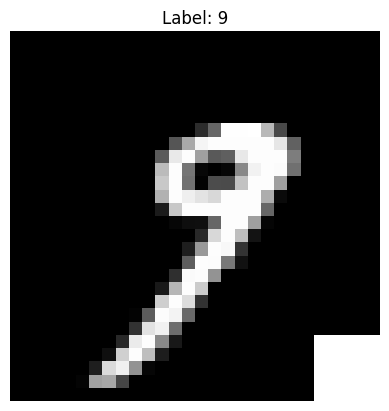

In [5]:
dfr_train_set = MNISTDataset(
    train=True,
    labels=[9, 7],
    main_spurious_features={9: top_left_square, 7: bottom_right_square},
    minority_spurious_features={9: bottom_right_square, 7: top_left_square},
    probabilities={7: 0.5, 9: 0.5},
)
dfr_loader = DataLoader(dfr_train_set, batch_size=64, shuffle=True)
dfr_train_set.view_item(5)

In [6]:
dfr_model = SimpleModel(num_classes=2)

model_path, tensorboard_path = deep_feature_reweighting(
    path_to_model=model_path,
    path_to_tensorboard_run=tensorboard_path,
    model=dfr_model,
    num_epochs=50,
    validation_loaders=validation_dataloaders,
    train_loader=dfr_loader,
    optimizer_type=torch.optim.Adam,
    lr=0.001,
    weight_decay=1e-3,
)

Reweighting Epochs:  84%|████████▍ | 42/50 [02:57<00:33,  4.22s/it, Train Loss=0.2117, Valid Loss Unbiased=0.1953, Train Accuracy=93.18%, Valid Accuracy Unbiased=0.942, Valid Accuracy Spurious=0.98, Valid Accuracy Opposite=0.904, Valid Worst Group Accuracy Unbiased=0.901, Valid Worst Group Accuracy Spurious=0.865, Valid Worst Group Accuracy Opposite=0.89]   

Early stopping triggered


In [7]:
tensorboard_path

'runs/13_12_2024_1021'

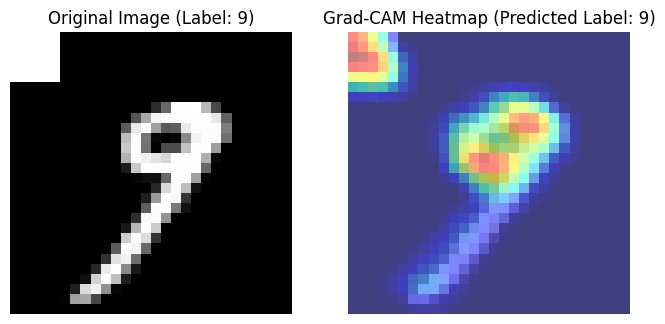

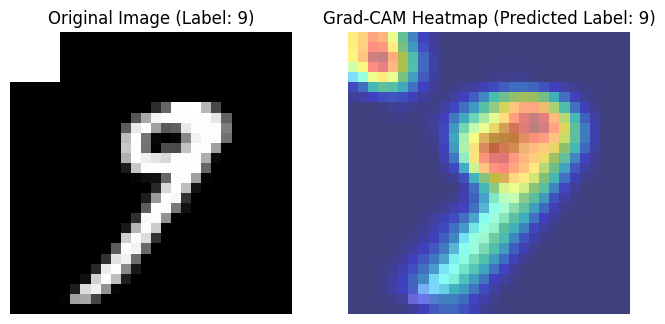

In [8]:
train_dataset.gradcam(model, 5, model.conv2)
train_dataset.gradcam(dfr_model, 5, dfr_model.conv2)